In [1]:
import pandas as pd
import requests
import time
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv('Analysis.csv')
qid_cache = {}

print(f"sucess， {len(df)} rows.")

sucess， 1647 rows.


In [2]:
def get_wikidata_nature(qid):
    if pd.isna(qid) or str(qid).strip() == '' or str(qid).lower() == 'nan':
        return None
    qid = str(qid).strip()
    if qid in qid_cache: return qid_cache[qid]
    
    query = f"SELECT ?type WHERE {{ wd:{qid} wdt:P31 ?type. }}"
    url = "https://query.wikidata.org/sparql"
    headers = {'User-Agent': 'DramaResearchBot/1.2'}
    
    try:
        r = requests.get(url, params={'format': 'json', 'query': query}, headers=headers, timeout=10)
        data = r.json()
        types = [item['type']['value'].split('/')[-1] for item in data['results']['bindings']]
# Classification logic: Q5 for Individual, other specified QIDs for Corporate
        if 'Q5' in types:
            res = "Individual"
        elif any(q in types for q in ['Q43229', 'Q2085381', 'Q4830453', 'Q41298', 'Q210278']):
            res = "Corporate"
        else:
            res = "Unknown"
        qid_cache[qid] = res
        return res
    except:
        return None

# Define classification logic
def hybrid_classify(row):
    pub_name = str(row['Publisher']).upper()
    pub_qid = row['Publisher_QID']
    
# Case-insensitive keyword classification
    if 'THE AUTHOR' in pub_name or 'PRINTED FOR THE AUTHOR' in pub_name:
        return 'Individual'
    
    corp_keywords = ['CO.', 'LTD', 'SONS', 'PRESS', 'COMPANY', 'BROTHERS', 'PUBLISH', 'INC.', '& CO', 'PRINTING OFFICE']
    if any(kw.upper() in pub_name for kw in corp_keywords):
        return 'Corporate'
    
    # Wikidata QID determination
    nature = get_wikidata_nature(pub_qid)
    return nature if nature else "Unknown"

# Execute classification
df['Publisher_Nature'] = df.apply(hybrid_classify, axis=1)
print("Classification complete!")


# Exclude Unknown
df_clean = df[df['Publisher_Nature'] != 'Unknown'].copy()

# Format year and convert to integer
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean = df_clean.dropna(subset=['Year']).copy()

df_clean['Year'] = df_clean['Year'].astype(int)

# Output processed data
print(f"Final valid data: {len(df_clean)} rows")
print("-" * 30)
print("\n[Current classification distribution]:")
print(df_clean['Publisher_Nature'].value_counts())

print("\n[Preview of classified data]:")
print(df_clean[['Publisher', 'Year', 'Publisher_Nature']])

Classification complete!
Final valid data: 436 rows
------------------------------

[Current classification distribution]:
Publisher_Nature
Corporate     373
Individual     63
Name: count, dtype: int64

[Preview of classified data]:
           Publisher  Year Publisher_Nature
0      Samuel French  1889        Corporate
13         T. Cadell  1778        Corporate
14       John Murray  1817        Corporate
15     Harrison; Co.  1788        Corporate
16         J. Parker  1794        Corporate
...              ...   ...              ...
1632     Sterne; Co.  1890        Corporate
1637             NaN  1886        Corporate
1638      the Author  1892       Individual
1639         Longman  1816        Corporate
1642  Macmillan; Co.  1890        Corporate

[436 rows x 3 columns]


In [3]:
# Convert categories to numeric: Corporate as 1, Individual as 0
df_clean['Is_Corporate'] = df_clean['Publisher_Nature'].map({'Corporate': 1, 'Individual': 0})

# Set independent variable X (Year) and dependent variable y (Is_Corporate)
X = sm.add_constant(df_clean['Year'])
y = df_clean['Is_Corporate']

# Fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Inflection Point: The year where the probability is exactly 50%
inflection_year = -result.params['const'] / result.params['Year']

# Odds Ratio: The factor by which the odds change for each additional year
odds_ratio = np.exp(result.params['Year'])

# Handle P-value display format
raw_p_value = result.pvalues['Year']
if raw_p_value < 0.01:
    p_value_display = "P < 0.01"
else:
    p_value_display = f"{raw_p_value:.4f}"

# Output Results
print()
print(result.summary())
print()
print("Result")

print(f"1. Inflection Year: {int(inflection_year)}")
print(f"2. Odds Ratio: {odds_ratio:.4f}")
print(f"(Increasing odds: {(odds_ratio-1)*100:.2f}%)")
print(f"3. P-value: {p_value_display}")

Optimization terminated successfully.
         Current function value: 0.256239
         Iterations 7

                           Logit Regression Results                           
Dep. Variable:           Is_Corporate   No. Observations:                  436
Model:                          Logit   Df Residuals:                      434
Method:                           MLE   Df Model:                            1
Date:                Thu, 01 Jan 2026   Pseudo R-squ.:                  0.3796
Time:                        02:58:07   Log-Likelihood:                -111.72
converged:                       True   LL-Null:                       -180.09
Covariance Type:            nonrobust   LLR p-value:                 1.381e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.2051      4.095     -9.330      0.000     -46.231     -30.179
Year           0.0222      0

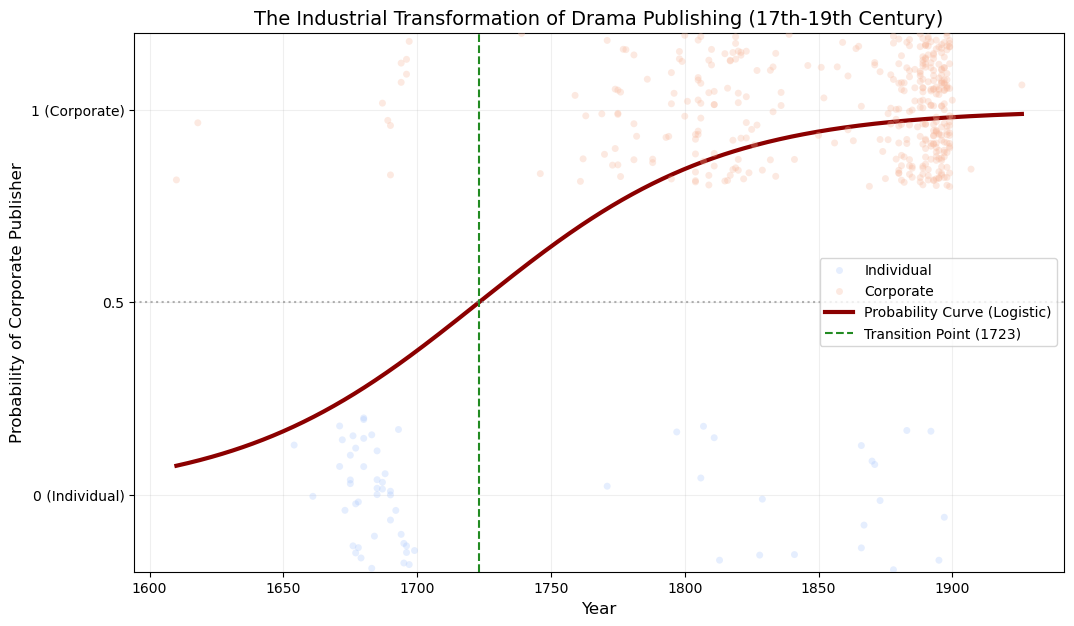

In [4]:
# Visualization: S-shaped Probability Growth Curve

# Generate prediction curve data
x_range = np.linspace(df_clean['Year'].min(), df_clean['Year'].max(), 500)
x_range_const = sm.add_constant(x_range)
y_prob = result.predict(x_range_const)

plt.figure(figsize=(12, 7))

# Plot raw data points
sns.stripplot(x='Year', y='Is_Corporate', hue=df_clean['Publisher_Nature'], data=df_clean, orient='h', alpha=0.3, palette='coolwarm', jitter=0.2, legend=True)

# Plot regression curve
plt.plot(x_range, y_prob, color='darkred', linewidth=3, label='Probability Curve (Logistic)')

# Mark the inflection point year
plt.axvline(inflection_year, color='forestgreen', linestyle='--', 
            label=f'Transition Point ({int(inflection_year)})')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.6)

# Axis and format settings
plt.title('The Industrial Transformation of Drama Publishing (17th-19th Century)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability of Corporate Publisher', fontsize=12)
plt.ylim(-0.2, 1.2) 
plt.yticks([0, 0.5, 1], ['0 (Individual)', '0.5', '1 (Corporate)'])

# Replace 0 and 1 in the legend with text
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
for label in labels:
    if label == '0': new_labels.append('Actual: Individual')
    elif label == '1': new_labels.append('Actual: Corporate')
    else: new_labels.append(label)

plt.legend(handles, new_labels, loc='center right', fontsize=10)
plt.grid(True, alpha=0.2)

plt.show()